In [1]:
import os
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

346

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
cmap_home = data_home + 'CMAP2020_Cancer/'
shift_home = poseidon_home + 'shift_ability/'
panel_home = poseidon_home + 'panels/Figure3/'

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

In [5]:
ec_color = df(index=gene_sets['NREC_profile'] + gene_sets['REC_profile'], columns=['colors'])
ec_color.loc[gene_sets['NREC_profile'], 'colors'] = 'crimson'
ec_color.loc[gene_sets['REC_profile'], 'colors'] = 'royalblue'

In [6]:
# L1000 gene info
bing_landmark = pd.read_csv(data_home + 'CMAP2020_Cancer/landmark_and_bings_L1000.csv',
                            header=0, index_col=0, sep=',', dtype={'Official NCBI gene symbol': 'str'}, converters={'Official NCBI gene symbol': None})
bing_landmark

,Official NCBI gene symbol
Official NCBI gene id,
5720,PSME1
7416,VDAC1
55847,CISD1
10174,SORBS3
25803,SPDEF
...,...
5137,PDE1C
51233,DRICH1
4340,MOG


In [7]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [8]:
sig_info

,bead_batch,nearest_dose,pert_dose,pert_dose_unit,pert_idose,pert_itime,pert_time,pert_time_unit,cell_mfc_name,pert_mfc_id,...,cell_iname,det_wells,det_plates,distil_ids,build_name,project_code,cmap_name,is_exemplar_sig,is_ncs_sig,is_null_sig
sig_id,,,,,,,,,,,,,,,,,,,,,
MET001_N8_XH:BRD-U44432129:100:336,b17,NaN,100.0,ug/ml,100 ug/ml,336 h,336.0,h,N8,BRD-U44432129,...,NAMEC8,H05|H06|H07|H08,MET001_N8_XH_X1_B17,MET001_N8_XH_X1_B17:H05|MET001_N8_XH_X1_B17:H0...,NaN,MET,BRD-U44432129,0,0.0,0.0
ABY001_A549_XH:BRD-K81418486:10:3,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,A549,BRD-K81418486,...,A549,L04|L08|L12,ABY001_A549_XH_X1_B15,ABY001_A549_XH_X1_B15:L04|ABY001_A549_XH_X1_B1...,NaN,ABY,vorinostat,0,1.0,0.0
ABY001_HT29_XH:BRD-K70511574:2.5:24,b15,2.5,2.5,uM,2.5 uM,24 h,24.0,h,HT29,BRD-K70511574,...,HT29,E18|E22,ABY001_HT29_XH_X1_B15,ABY001_HT29_XH_X1_B15:E18|ABY001_HT29_XH_X1_B1...,NaN,ABY,HMN-214,0,1.0,0.0
LTC002_HME1_3H:BRD-K81418486:10,b18,10.0,10.0,uM,10 uM,3 h,3.0,h,HME1,BRD-K81418486,...,HME1,F19,LTC002_HME1_3H_X1_B18,LTC002_HME1_3H_X1_B18:F19,NaN,LTC,vorinostat,0,0.0,0.0
ABY001_H1975_XH:BRD-A61304759:10:3,b15,10.0,10.0,uM,10 uM,3 h,3.0,h,H1975,BRD-A61304759,...,H1975,P01|P05|P09,ABY001_H1975_XH_X1_B15,ABY001_H1975_XH_X1_B15:P01|ABY001_H1975_XH_X1_...,NaN,ABY,tanespimycin,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DOSVAL001_HCC515_24H:BRD-K48853221:10,b18,10.0,10.0,uM,10 uM,24 h,24.0,h,HCC515,BRD-K48853221,...,HCC515,K01,DOSVAL001_HCC515_24H_X1_B18|DOSVAL001_HCC515_2...,DOSVAL001_HCC515_24H_X1_B18:K01|DOSVAL001_HCC5...,NaN,DOSVAL,BRD-K48853221,1,1.0,0.0
DOSVAL001_HCC515_24H:BRD-K90382497:10,b18,10.0,10.0,uM,10 uM,24 h,24.0,h,HCC515,BRD-K90382497,...,HCC515,O03,DOSVAL001_HCC515_24H_X1_B18|DOSVAL001_HCC515_2...,DOSVAL001_HCC515_24H_X1_B18:O03|DOSVAL001_HCC5...,NaN,DOSVAL,GW-843682X,0,1.0,0.0
DOSVAL002_HCC515_24H:BRD-K45785972:20,b19,20.0,20.0,uM,20 uM,24 h,24.0,h,HCC515,BRD-K45785972,...,HCC515,M22,DOSVAL002_HCC515_24H_X1.L2_B19|DOSVAL002_HCC51...,DOSVAL002_HCC515_24H_X1.L2_B19:M22|DOSVAL002_H...,NaN,DOSVAL,BRD-K45785972,0,1.0,0.0


In [9]:
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()
compound_info

,pert_id,target,moa,canonical_smiles,inchi_key,compound_aliases
cmap_name,,,,,,
1-EBIO,BRD-K70586315,NaN,NaN,CCn1c2ccccc2[nH]c1=O,CXUCKELNYMZTRT-UHFFFAOYSA-N,NaN
1-HYDROXYANTHRAQUINONE,BRD-K62620932,NaN,NaN,NaN,NaN,NaN
1-HYDROXYPHENAZINE,BRD-K66151076,NaN,NaN,NaN,NaN,NaN
1-NAPHTHYLAMINE,BRD-K05741221,NaN,NaN,NaN,NaN,NaN
1-NITRONAPHTHALENE,BRD-K72839221,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
zolpidem,BRD-K44876623,GABRA1,Benzodiazepine receptor agonist,CN(C)C(=O)Cc1c(nc2ccc(C)cn12)-c1ccc(C)cc1,ZAFYATHCZYHLPB-UHFFFAOYSA-N,NaN
zonisamide,BRD-A28095882,SCN11A,Sodium channel blocker,CN1C2CCC1CC(C2)OC(c3ccccc3)c4ccccc4N,KZFDKINRISJFCO-UHFFFAOYSA-N,NaN
zopiclone,BRD-A34309505,GABRA1,GABA receptor agonist,CN1CCN(CC1)C(=O)OC2N(C(=O)c3nccnc23)c4ccc(Cl)cn4,GBBSUAFBMRNDJC-UHFFFAOYSA-N,NaN


In [10]:
compound_info['moa'].value_counts()

Dopamine receptor antagonist                   64
Cyclooxygenase inhibitor                       62
Adrenergic receptor antagonist                 56
Histamine receptor antagonist                  54
Serotonin receptor antagonist                  50
                                               ..
Glucose 6-phosphate dehydrogenase inhibitor     1
Plasminogen activator inhibitor                 1
Monamine transporter modulator                  1
Cardiac myosin activator                        1
Glycine receptor antagonist                     1
Name: moa, Length: 581, dtype: int64

# Read all compound results

In [11]:
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']

In [12]:
# read the compound enrichment results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    print(ct, compound_result[ct].shape)

BLCA (5, 6)
BRCA (9573, 6)
CESC (2906, 6)
CRC (4516, 6)
LIHC (2361, 6)
LUNG (6901, 6)
OV (53, 6)
PAAD (1906, 6)
PRAD (8107, 6)
SKCM (4917, 6)
STAD (38, 6)
UCEC (38, 6)


In [13]:
all_cell_line = []
for ct in compound_cancer:
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        if tmp_shift_cl.shape[0] < 100: # skip cell lines with too few experiments
            continue
        all_cell_line.append(cl)

In [14]:
all_cell_line

['MCF7',
 'SKBR3',
 'MDAMB231',
 'BT20',
 'HS578T',
 'HELA',
 'HT29',
 'HEPG2',
 'HUH7',
 'A549',
 'HCC515',
 'YAPC',
 'PC3',
 'LNCAP',
 'VCAP',
 'A375',
 'SKMEL5']

# 0. Distribution of shift ability

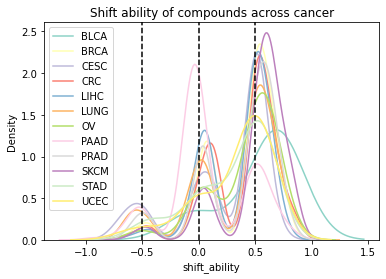

In [15]:
sns.set_palette('Set3')
for ct in compound_cancer:
    sns.kdeplot(compound_result[ct]['shift_ability'], label=ct)
plt.legend(loc='best')
plt.axvline(x=0.0, ls='--', c='k')
plt.axvline(x=0.5, ls='--', c='k')
plt.axvline(x=-0.5, ls='--', c='k')
plt.title('Shift ability of compounds across cancer')
fig = plt.gcf()
fig.savefig(panel_home + 'shift_ability_dis.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'shift_ability_dis.pdf', transparent=True)

In [16]:
# show top shifting compound in each cancer type and cell lines
for ct in compound_cancer:
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        if tmp_shift_cl.shape[0] < 100: # skip cell lines with too few experiments
            continue
        tmp_shift_cl = tmp_shift_cl.sort_values(by='shift_ability', ascending=False)
        
        # print result
        print(ct, cl)
        print('top shifting to R')
        print(list(tmp_shift_cl[:20]['cmap_name'].unique())) # top 20
        print('top shifting to NR')
        print(list(tmp_shift_cl[-20:]['cmap_name'].unique())) # bottom 20
        print('\n')

BRCA MCF7
top shifting to R
['floxuridine', 'tipifarnib', 'fulvestrant', 'valrubicin', 'epirubicin', 'camptothecin', 'raloxifene', 'mitoxantrone', 'palbociclib', 'gemcitabine', 'JNJ-26481585', 'AMG-232', 'BRD-K68007270', 'alisertib', 'BRD-K63750851']
top shifting to NR
['triciribine', 'torin-2', 'KX-2391', 'BRD-K71935468', 'emetine', 'BRD-K32896438', 'BRD-K39345836', 'LY-2090314', 'RVE-VIII-11', 'ON-01910', 'withaferin-a', 'azacitidine', 'narciclasine']


BRCA SKBR3
top shifting to R
['CP-724714', 'withaferin-a', 'neratinib', 'BRD-K04887706', 'alpelisib', 'lapatinib', 'afatinib', 'pelitinib', 'JNK-9L', 'NVP-BEZ235', 'GDC-0980', 'AZD-6482', 'CGP-60474', 'BMS-345541', 'mitoxantrone']
top shifting to NR
['GW-843682X', 'BMS-345541', 'radicicol', 'THZ-2-98-01', 'trametinib', 'KIN001-043', 'NVP-AUY922', 'PD-0325901', 'BRD-K04923131', 'NVP-TAE684', 'HG-6-64-01', 'CHIR-99021']


BRCA MDAMB231
top shifting to R
['dasatinib', 'MEK-162', 'NVP-TAE684', 'palbociclib', 'pitavastatin', 'foretinib', '

In [17]:
# heatmap showing compounds with shift ability higher than n in each cell line
def visual_top_n(n, cancer_list, shift_result, sig_info):
    top_R_merged = {}
    top_NR_merged = {}

    for ct in cancer_list:
        tmp_shift = shift_result[ct]
        tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

        for cl in tmp_sig['cell_mfc_name'].unique():
            tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
            tmp_shift_cl = tmp_shift_cl.sort_values(by='shift_ability', ascending=False)
            
            if tmp_shift_cl.shape[0] < 100: # skip cell lines with too few experiments
                continue

            tmp_to_R = tmp_shift_cl[tmp_shift_cl['shift_ability'] >= n]['cmap_name'].unique()

            top_R_merged[cl] = tmp_to_R
    
    # build a mutual exclusive matrix
    top_R_matrix = df(columns=top_R_merged.keys())
    
    for cl in top_R_merged.keys():
        for g in top_R_merged[cl]:
            top_R_matrix.at[g, cl] = 1

    # visualize
    plt.figure(figsize=(5, 5))
    sns.heatmap(top_R_matrix.fillna(0), square=False, cmap='Reds')
    plt.show()
    
    return top_R_matrix

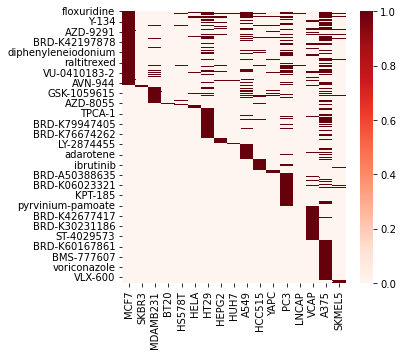

In [18]:
top_R = visual_top_n(n=0.7,
                     cancer_list=compound_cancer,
                     shift_result=compound_result,
                     sig_info=sig_info)

In [19]:
top_R.shape

(771, 17)

In [20]:
# drug counts
drug_count = df(top_R.sum(axis=1)).sort_values(by=0, ascending=False)
drug_count['moa'] = compound_info['moa']
drug_count['target'] = compound_info['target']
drug_count[:50]

,0,moa,target
mitoxantrone,11.0,Topoisomerase inhibitor,TOP2A
doxorubicin,10.0,Topoisomerase inhibitor,TOP2A
AZD-7762,8.0,CHK inhibitor,CHEK1
withaferin-a,8.0,IKK inhibitor,NAMPT
sirolimus,8.0,MTOR inhibitor,FKBP1A
gemcitabine,8.0,Ribonucleotide reductase inhibitor,RRM1
alvocidib,8.0,CDK inhibitor,CDK2
vorinostat,8.0,HDAC inhibitor,HDAC6
CGP-60474,8.0,CDK inhibitor,CDK1
daunorubicin,7.0,RNA synthesis inhibitor,TOP2A


In [21]:
# visual by each cell line, show NREC and REC score, label the tops, only show the R-shifting (> 0.5)
merged_rs_cp_list = []
for ct in compound_cancer:
    tmp_shift = compound_result[ct]
    tmp_sig = sig_info[sig_info.index.isin(tmp_shift.index)]

    for cl in tmp_sig['cell_mfc_name'].unique():
        tmp_shift_cl = tmp_shift[tmp_shift.index.isin(tmp_sig[tmp_sig['cell_mfc_name'] == cl].index)]
        if tmp_shift_cl.shape[0] < 100: # skip cell lines with too few experiments
            continue
        tmp_shift_cl['cell_line'] = cl
        tmp_shift_cl['cancer_type'] = ct
        merged_rs_cp_list.append(tmp_shift_cl[tmp_shift_cl['shift_ability'] >= 0.5])

merged_rs_cp_table = pd.concat(merged_rs_cp_list, axis=0)
print(merged_rs_cp_table)
merged_rs_cp_table.to_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_table.csv', sep=',')  

<ipython-input-21-3a2a70ae3863>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_shift_cl['cell_line'] = cl
<ipython-input-21-3a2a70ae3863>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_shift_cl['cancer_type'] = ct
<ipython-input-21-3a2a70ae3863>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

                         NREC_profile  REC_profile    cmap_name  nearest_dose  \
REP.A023_MCF7_24H:P14       -0.471999     0.456107  floxuridine         3.330   
LKCP002_MCF7_48H:B10        -0.458585     0.468354   tipifarnib        10.000   
PBIOA016_MCF7_24H:H03       -0.470885     0.447807  fulvestrant         1.110   
REP.A023_MCF7_24H:O15       -0.503013     0.412289   valrubicin         1.110   
REP.A015_MCF7_24H:E11       -0.473579     0.441700   epirubicin         0.125   
...                               ...          ...          ...           ...   
AICHI002_SKMEL5_24H:M12     -0.249891     0.269380   dinaciclib         0.010   
EMU001_SKMEL5_24H:K14       -0.303896     0.212090   paclitaxel         2.500   
AICHI002_SKMEL5_24H:M13     -0.339857     0.167980       CINK-4        10.000   
EMU001_SKMEL5_24H:O13       -0.295800     0.206277  LCB-03-0110        10.000   
AICHI002_SKMEL5_24H:N01     -0.292263     0.209703  PF-05212384        10.000   

                        per

<AxesSubplot:xlabel='shift_ability', ylabel='cell_line'>

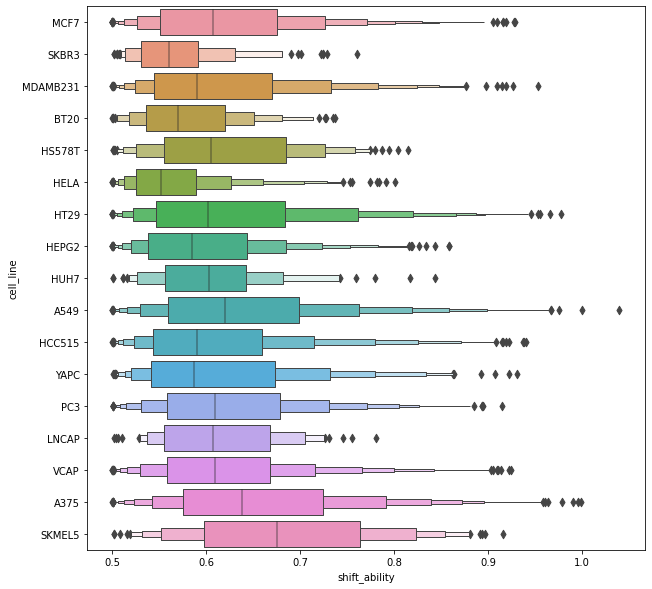

In [22]:
plt.figure(figsize=(10, 10))
sns.boxenplot(x='shift_ability', y='cell_line', data=merged_rs_cp_table)

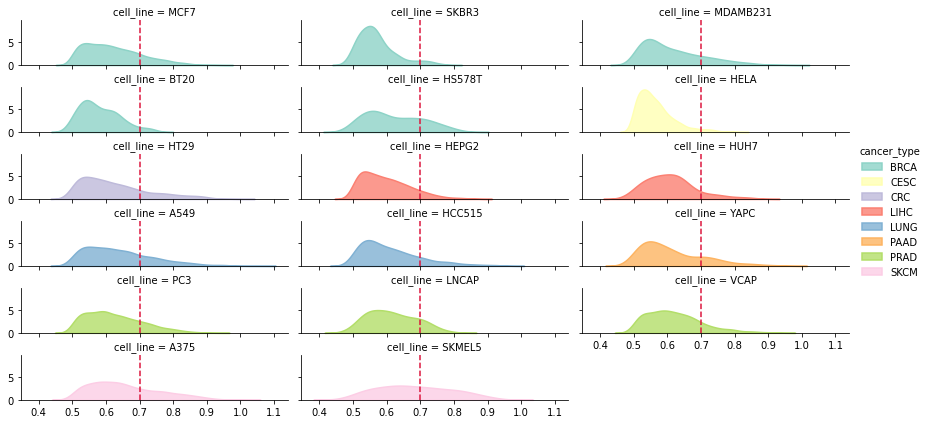

In [23]:
g = sns.FacetGrid(merged_rs_cp_table, col='cell_line', col_wrap=3, hue='cancer_type',
                  row_order=all_cell_line, aspect=4, height=1)

g.map_dataframe(sns.kdeplot, 'shift_ability',
      clip_on=False, bw_adjust=1,
      fill=True, alpha=0.8, linewidth=1.5)
g.map(plt.axvline, x=0.7, ls='--', c='crimson')
g.fig.subplots_adjust(wspace=0.05, hspace=0.5)
g.add_legend()

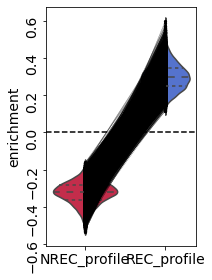

In [24]:
plt.figure(figsize=(3, 4))
sns.violinplot(x='variable', y='value',
               inner='quartile',
               data=pd.melt(merged_rs_cp_table[['NREC_profile', 'REC_profile']]),
               palette={'NREC_profile': 'crimson', 'REC_profile': 'royalblue'})

plt.scatter(np.zeros(len(merged_rs_cp_table.index)),
            merged_rs_cp_table.loc[merged_rs_cp_table.index, 'NREC_profile'],
            s=5, c='k')
plt.scatter(np.ones(len(merged_rs_cp_table.index)),
            merged_rs_cp_table.loc[merged_rs_cp_table.index, 'REC_profile'],
            s=5, c='k')
for i in merged_rs_cp_table.index:
    plt.plot([0, 1],
             [merged_rs_cp_table.loc[i, 'NREC_profile'],
              merged_rs_cp_table.loc[i, 'REC_profile']], c='k', linewidth=0.2)

plt.axhline(y=0., c='k', ls='--')
plt.ylabel('enrichment', fontsize=14)
plt.xlabel('')
plt.yticks(rotation=90, fontsize=14)
plt.xticks(fontsize=14)
plt.tight_layout()

In [25]:
for cl in merged_rs_cp_table['cell_line'].unique():
    tmp_rs = merged_rs_cp_table[merged_rs_cp_table['cell_line'] == cl]
    tmp_rs = tmp_rs.rename(columns={'NREC_profile': 'NREC', 'REC_profile': 'REC'})
    plt.figure(figsize=(2, 4))
    sns.violinplot(x='variable', y='value',
                   inner='quartile',
                   data=pd.melt(tmp_rs[['NREC', 'REC']]),
                   palette={'NREC': 'crimson', 'REC': 'royalblue'})

    plt.scatter(np.zeros(len(tmp_rs.index)),
                tmp_rs.loc[tmp_rs.index, 'NREC'],
                s=5, c='k')
    plt.scatter(np.ones(len(tmp_rs.index)),
                tmp_rs.loc[tmp_rs.index, 'REC'],
                s=5, c='k')
    for i in tmp_rs.index:
        plt.plot([0, 1],
                 [tmp_rs.loc[i, 'NREC'],
                  tmp_rs.loc[i, 'REC']], c='grey', ls='--', linewidth=0.1)

    plt.axhline(y=0., c='k', ls='--')
    plt.ylabel('TEC score', fontsize=14)
    plt.xlabel('')
    plt.yticks(rotation=90, fontsize=14)
    plt.xticks(fontsize=14)
    plt.title(cl)
    plt.tight_layout()
    
    fig=plt.gcf()
    fig.savefig(panel_home + 'violin_shift/' + cl + '.png', dpi=300, transparent=True)
    fig.savefig(panel_home + 'violin_shift/' + cl + '.pdf', transparent=True)
    
    plt.close()

## Dosage

In [26]:
# add dosage category
merged_rs_cp_table['dosage'] = 'not available'
merged_rs_cp_table.loc[merged_rs_cp_table[merged_rs_cp_table['nearest_dose'] <= 1 ].index, 'dosage'] = 'low'
merged_rs_cp_table.loc[merged_rs_cp_table[(merged_rs_cp_table['nearest_dose'] <= 10 ) & (merged_rs_cp_table['nearest_dose'] > 1)].index, 'dosage'] = 'medium'
merged_rs_cp_table.loc[merged_rs_cp_table[merged_rs_cp_table['nearest_dose'] > 10].index, 'dosage'] = 'high'

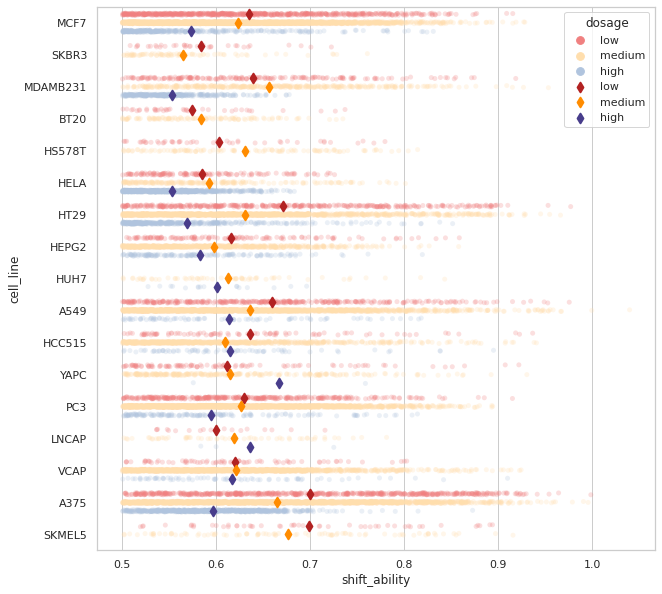

In [27]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 10))
sns.stripplot(x='shift_ability', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
              data=merged_rs_cp_table, dodge=True, alpha=.25, zorder=1)

sns.pointplot(x='shift_ability', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'firebrick', 'medium': 'darkorange', 'high': 'darkslateblue'},
              data=merged_rs_cp_table, dodge=.8 - .8 / 3,
              join=False, markers="d", scale=1, ci=None)

fig = plt.gcf()
fig.savefig(panel_home + 'dis_shift_ability_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'dis_shift_ability_dosage.pdf', transparent=True)

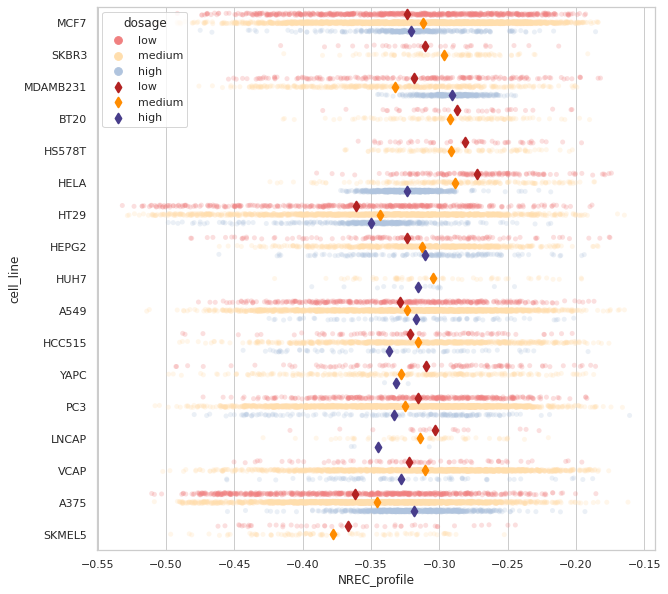

In [28]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 10))
sns.stripplot(x='NREC_profile', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
              data=merged_rs_cp_table, dodge=True, alpha=.25, zorder=1)

sns.pointplot(x='NREC_profile', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'firebrick', 'medium': 'darkorange', 'high': 'darkslateblue'},
              data=merged_rs_cp_table, dodge=.8 - .8 / 3,
              join=False, markers="d", scale=1, ci=None)

fig = plt.gcf()
fig.savefig(panel_home + 'dis_NREC_score_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'dis_NREC_score_dosage.pdf', transparent=True)

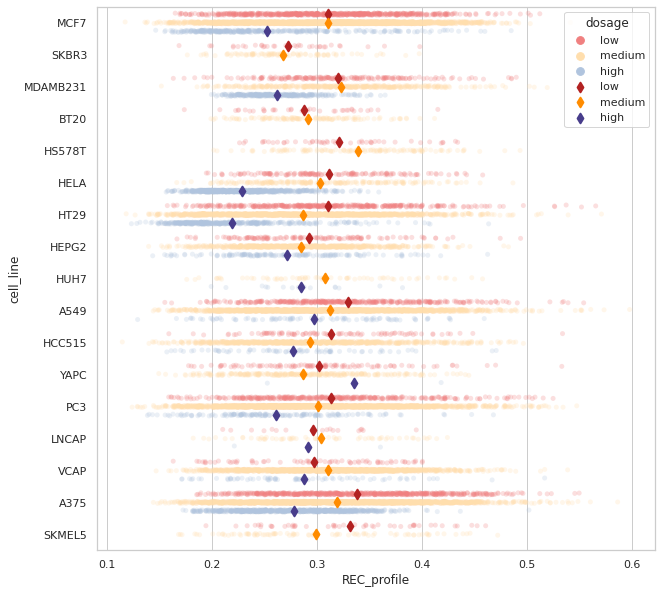

In [29]:
sns.set_theme(style='whitegrid')
plt.figure(figsize=(10, 10))
sns.stripplot(x='REC_profile', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
              data=merged_rs_cp_table, dodge=True, alpha=.25, zorder=1)

sns.pointplot(x='REC_profile', y='cell_line', hue='dosage', hue_order=['low', 'medium', 'high'],
              palette={'low': 'firebrick', 'medium': 'darkorange', 'high': 'darkslateblue'},
              data=merged_rs_cp_table, dodge=.8 - .8 / 3,
              join=False, markers="d", scale=1, ci=None)

fig = plt.gcf()
fig.savefig(panel_home + 'dis_REC_score_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'dis_REC_score_dosage.pdf', transparent=True)

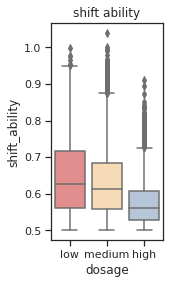

In [30]:
sns.set_theme(style='ticks')
plt.figure(figsize=(2, 4))
sns.boxplot(y='shift_ability', x='dosage', order=['low', 'medium', 'high'],
            palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
            data=merged_rs_cp_table)
plt.title('shift ability')
fig = plt.gcf()
fig.savefig(panel_home + 'all_shift_ability_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'all_shift_ability_dosage.pdf', transparent=True)

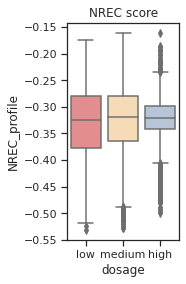

In [31]:
sns.set_theme(style='ticks')
plt.figure(figsize=(2, 4))
sns.boxplot(y='NREC_profile', x='dosage', order=['low', 'medium', 'high'],
            palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
            data=merged_rs_cp_table)
plt.title('NREC score')
fig = plt.gcf()
fig.savefig(panel_home + 'all_NREC_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'all_NREC_dosage.pdf', transparent=True)

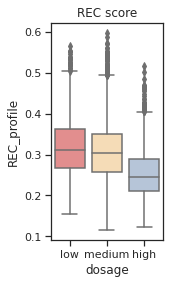

In [32]:
sns.set_theme(style='ticks')
plt.figure(figsize=(2, 4))
sns.boxplot(y='REC_profile', x='dosage', order=['low', 'medium', 'high'],
            palette={'low': 'lightcoral', 'medium': 'navajowhite', 'high': 'lightsteelblue'},
            data=merged_rs_cp_table)
plt.title('REC score')
fig = plt.gcf()
fig.savefig(panel_home + 'all_REC_dosage.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'all_REC_dosage.pdf', transparent=True)

<AxesSubplot:xlabel='shift_ability', ylabel='nearest_dose'>

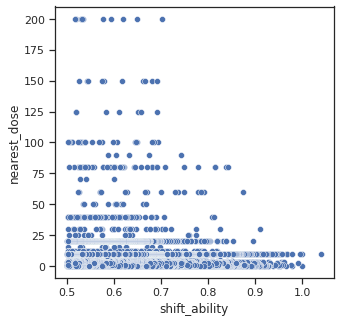

In [33]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='shift_ability', y='nearest_dose', data=merged_rs_cp_table)

In [34]:
merged_rs_cp_table

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cell_line,cancer_type,dosage
REP.A023_MCF7_24H:P14,-0.471999,0.456107,floxuridine,3.330,3.33 uM,0.928106,MCF7,BRCA,medium
LKCP002_MCF7_48H:B10,-0.458585,0.468354,tipifarnib,10.000,10 uM,0.926939,MCF7,BRCA,medium
PBIOA016_MCF7_24H:H03,-0.470885,0.447807,fulvestrant,1.110,1.11 uM,0.918692,MCF7,BRCA,medium
REP.A023_MCF7_24H:O15,-0.503013,0.412289,valrubicin,1.110,1.11 uM,0.915302,MCF7,BRCA,medium
REP.A015_MCF7_24H:E11,-0.473579,0.441700,epirubicin,0.125,0.125 uM,0.915279,MCF7,BRCA,low
...,...,...,...,...,...,...,...,...,...
AICHI002_SKMEL5_24H:M12,-0.249891,0.269380,dinaciclib,0.010,0.01 uM,0.519271,SKMEL5,SKCM,low
EMU001_SKMEL5_24H:K14,-0.303896,0.212090,paclitaxel,2.500,2.5 uM,0.515986,SKMEL5,SKCM,medium
AICHI002_SKMEL5_24H:M13,-0.339857,0.167980,CINK-4,10.000,10 uM,0.507837,SKMEL5,SKCM,medium
EMU001_SKMEL5_24H:O13,-0.295800,0.206277,LCB-03-0110,10.000,10 uM,0.502077,SKMEL5,SKCM,medium


In [58]:
# dosage-dependence in each cell line
dose_dep = df(columns=['shift_r', 'shift_p', 'NREC_r', 'NREC_p',
                       'REC_r', 'REC_p', 'tas_r', 'tas_p', 'cell_line', 'cancer_type',
                       'cmap_name', '#experiments', 'moa', 'target'])
for ct in merged_rs_cp_table['cancer_type'].unique():
    tmp_rs = merged_rs_cp_table[merged_rs_cp_table['cancer_type'] == ct]
    for cl in tmp_rs['cell_line'].unique():
        tmp_rs_cl = tmp_rs[tmp_rs['cell_line'] == cl]
        for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                tmp_s_r, tmp_s_p = stats.spearmanr(tmp_rs_cl_d['shift_ability'], tmp_rs_cl_d['nearest_dose'])
                tmp_n_r, tmp_n_p = stats.spearmanr(tmp_rs_cl_d['NREC_profile'], tmp_rs_cl_d['nearest_dose'])
                tmp_r_r, tmp_r_p = stats.spearmanr(tmp_rs_cl_d['REC_profile'], tmp_rs_cl_d['nearest_dose'])
                tmp_t_r, tmp_t_p = stats.spearmanr(sig_info.loc[tmp_rs_cl_d.index, 'tas'], sig_info.loc[tmp_rs_cl_d.index, 'nearest_dose'])
                
                dose_dep.at[cl + '_' + d, 'shift_r'] = tmp_s_r
                dose_dep.at[cl + '_' + d, 'shift_p'] = tmp_s_p
                dose_dep.at[cl + '_' + d, 'NREC_r'] = tmp_n_r
                dose_dep.at[cl + '_' + d, 'NREC_p'] = tmp_n_p
                dose_dep.at[cl + '_' + d, 'REC_r'] = tmp_r_r
                dose_dep.at[cl + '_' + d, 'REC_p'] = tmp_r_p
                dose_dep.at[cl + '_' + d, 'tas_r'] = tmp_t_r
                dose_dep.at[cl + '_' + d, 'tas_p'] = tmp_t_p
                dose_dep.at[cl + '_' + d, 'cancer_type'] = ct
                dose_dep.at[cl + '_' + d, 'cell_line'] = cl
                dose_dep.at[cl + '_' + d, 'cmap_name'] = d
                dose_dep.at[cl + '_' + d, '#experiments'] = tmp_rs_cl_d.shape[0]
                dose_dep.at[cl + '_' + d, 'moa'] = compound_info.loc[d, 'moa']
                dose_dep.at[cl + '_' + d, 'target'] = compound_info.loc[d, 'target']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [53]:
# get the full list of experiments that included in dose dependence measurements
dose_dep_sig_id = []
for ct in merged_rs_cp_table['cancer_type'].unique():
    tmp_rs = merged_rs_cp_table[merged_rs_cp_table['cancer_type'] == ct]
    for cl in tmp_rs['cell_line'].unique():
        tmp_rs_cl = tmp_rs[tmp_rs['cell_line'] == cl]
        for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                dose_dep_sig_id.extend(list(tmp_rs_cl_d.index))

In [54]:
len(dose_dep_sig_id)

11363

In [55]:
dose_dep_sig_info = sig_info[sig_info.index.isin(dose_dep_sig_id)]

In [56]:
dose_dep_sig_info.to_csv(poseidon_home + 'results/compound_top_moa/dose_dep_sig_info.csv', sep=',')

In [59]:
dose_dep = dose_dep.dropna(axis=0, how='any')

In [60]:
dose_dep[dose_dep['cmap_name'] == 'PF-03758309']

,shift_r,shift_p,NREC_r,NREC_p,REC_r,REC_p,tas_r,tas_p,cell_line,cancer_type,cmap_name,#experiments,moa,target
MCF7_PF-03758309,-0.4,0.504632,-0.1,0.872889,-0.5,0.391002,1,1.40427e-24,MCF7,BRCA,PF-03758309,5,P21 activated kinase inhibitor,PAK4
HT29_PF-03758309,-0.0120491,0.97741,-0.25303,0.545429,-0.361472,0.378964,0.951876,0.000268663,HT29,CRC,PF-03758309,8,P21 activated kinase inhibitor,PAK4
YAPC_PF-03758309,1,1.40427e-24,-1,1.40427e-24,0.8,0.104088,0.7,0.18812,YAPC,PAAD,PF-03758309,5,P21 activated kinase inhibitor,PAK4
PC3_PF-03758309,-0.268058,0.282166,-0.0311695,0.902284,-0.238966,0.339578,0.811447,4.36224e-05,PC3,PRAD,PF-03758309,18,P21 activated kinase inhibitor,PAK4
A375_PF-03758309,0.553317,0.122249,-0.451166,0.222869,0.255377,0.507201,0.655468,0.0552934,A375,SKCM,PF-03758309,9,P21 activated kinase inhibitor,PAK4


In [61]:
dose_dep.to_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_dose_dependence.csv', sep=',')

In [137]:
dose_dep['cancer_type'].unique()

array(['BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG', 'PAAD', 'PRAD', 'SKCM'],
      dtype=object)

In [62]:
dose_dep.shape

(579, 14)

In [63]:
dose_dep['shift_r'] = dose_dep['shift_r'].astype(float)
dose_dep['NREC_r'] = dose_dep['NREC_r'].astype(float)
dose_dep['REC_r'] = dose_dep['REC_r'].astype(float)
dose_dep['tas_r'] = dose_dep['tas_r'].astype(float)

In [41]:
pd.crosstab(dose_dep['cmap_name'], dose_dep['cancer_type'])

cancer_type,BRCA,CESC,CRC,LIHC,LUNG,PAAD,PRAD,SKCM
cmap_name,,,,,,,,
5-iodotubercidin,0,0,0,0,1,0,1,0
AG-14361,1,0,0,0,0,0,0,0
AMG-232,1,0,0,0,1,0,0,1
AS-605240,0,0,0,0,0,0,0,1
AS-703026,0,0,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...
vemurafenib,0,0,1,0,0,0,0,1
volasertib,0,0,0,0,0,0,0,1
vorinostat,1,0,1,1,2,0,2,2


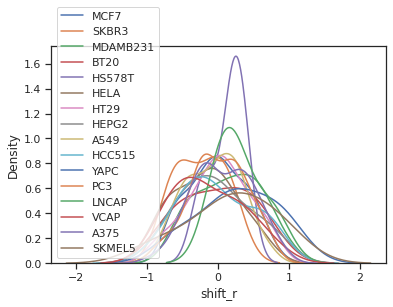

In [42]:
for ct in dose_dep['cell_line'].unique():
    tmp = dose_dep[dose_dep['cell_line'] == ct]
    sns.kdeplot(tmp['shift_r'], label=ct)
plt.legend(loc='best')

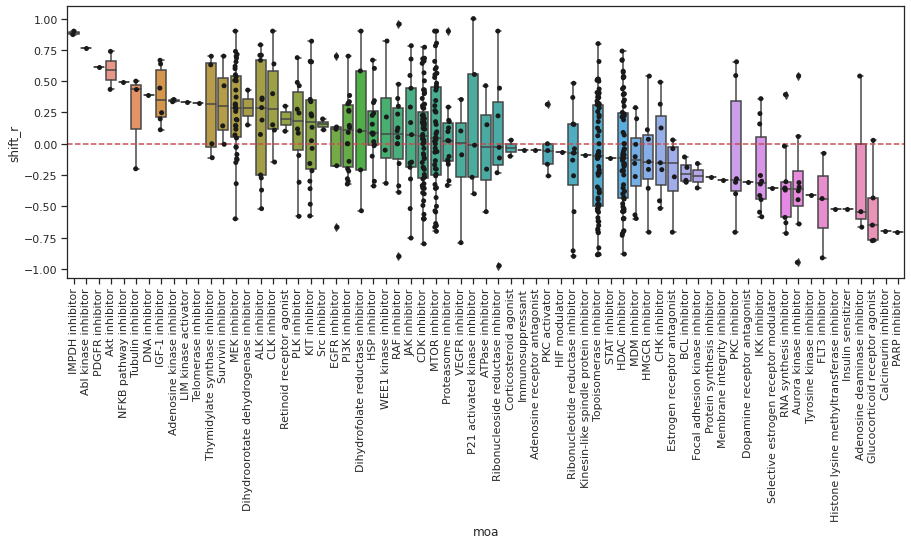

In [43]:
plt.figure(figsize=(15, 5))
sns.boxplot(x='moa', y='shift_r',
            order=df(dose_dep.groupby(['moa']).median()).sort_values(by='shift_r', ascending=False).index,
            data=dose_dep)

sns.stripplot(x='moa', y='shift_r',
            order=df(dose_dep.groupby(['moa']).median()).sort_values(by='shift_r', ascending=False).index,
            color='k', size=5, data=dose_dep)

plt.xticks(rotation=90)
plt.axhline(y=0.0, ls='--', color='r')
fig = plt.gcf()
fig.savefig(panel_home + 'dose_dependence_by_moa.png', transparent=True, dpi=300)
fig.savefig(panel_home + 'dose_dependence_by_moa.pdf', transparent=True)

In [44]:
# pos corr and neg corr in each moa
for m in dose_dep['moa'].unique():
    tmp = dose_dep[dose_dep['moa'] == m]
    print(m)
    print(np.round(tmp['shift_r'].min(), 4))
    print(df(tmp[tmp['shift_r'] == tmp['shift_r'].min()]['cancer_type']))
    print(np.round(tmp['shift_r'].max(), 4))
    print(df(tmp[tmp['shift_r'] == tmp['shift_r'].max()]['cancer_type']))
    print('\n')

Estrogen receptor antagonist
-0.7071
               cancer_type
MCF7_clomifene        BRCA
0.03
                 cancer_type
MCF7_fulvestrant        BRCA


Topoisomerase inhibitor
-0.8879
                cancer_type
HT29_epirubicin         CRC
0.8
                cancer_type
HEPG2_topotecan        LIHC


CDK inhibitor
-0.8
                cancer_type
HT29_dinaciclib         CRC
0.7714
                cancer_type
LNCAP_alvocidib        PRAD


Ribonucleotide reductase inhibitor
-0.9
                  cancer_type
HEPG2_gemcitabine        LIHC
0.4831
                cancer_type
HT29_cytarabine         CRC


HDAC inhibitor
-0.8819
                  cancer_type
SKMEL5_vorinostat        SKCM
0.7407
               cancer_type
PC3_belinostat        PRAD


MDM inhibitor
-0.5976
              cancer_type
A375_nutlin-3        SKCM
0.2887
               cancer_type
HEPG2_nutlin-3        LIHC


Aurora kinase inhibitor
-0.9487
                cancer_type
A549_danusertib        LUNG
0.5429
           

In [45]:
dose_dep[dose_dep['moa'] == 'PARP inhibitor']

,shift_r,shift_p,NREC_r,NREC_p,REC_r,REC_p,cell_line,cancer_type,cmap_name,#experiments,moa,target
MCF7_AG-14361,-0.707107,0.18169,-0.353553,0.559404,-0.353553,0.559404,MCF7,BRCA,AG-14361,5,PARP inhibitor,PARP1


In [115]:
## Dosage dependence: selected cases
def scatter_dose_dep(cell_line, compound, merged_rs_cp_table, tas, dose_dep_table):
    '''
    Scatterplot selected cases
    '''
    tmp_rs = merged_rs_cp_table[merged_rs_cp_table['cell_line'] == cell_line]
    tmp_rs_cp = tmp_rs[tmp_rs['cmap_name'] == compound]
    tmp_rs_cp['tas'] = tas['tas']
    
    f, axes = plt.subplots(1, 3, figsize=(8, 3))
    im=axes[0].scatter(x='nearest_dose', y='shift_ability', c='tas',
                   data=tmp_rs_cp, vmin=.4, vmax=1., cmap='Oranges')
    plt.sca(axes[0])
    plt.title('shift_ability\nrho = ' + np.str(np.round(dose_dep_table.loc[cell_line + '_' + compound, 'shift_r'], 4)))
    plt.yticks(rotation=90)
    plt.tight_layout()
    
    im=axes[1].scatter(x='nearest_dose', y='NREC_profile',c='tas',
                   data=tmp_rs_cp, vmin=.4, vmax=1., cmap='Oranges')
    plt.sca(axes[1])
    plt.title('NREC_profile\nrho = ' + np.str(np.round(dose_dep_table.loc[cell_line + '_' + compound, 'NREC_r'], 4)))
    plt.yticks(rotation=90)
    plt.tight_layout()
    
    im=axes[2].scatter(x='nearest_dose', y='REC_profile', c='tas',
                   data=tmp_rs_cp, vmin=.4, vmax=1., cmap='Oranges')
    plt.sca(axes[2])
    plt.title('REC_profile\nrho = ' + np.str(np.round(dose_dep_table.loc[cell_line + '_' + compound, 'REC_r'], 4)))
    plt.yticks(rotation=90)
    plt.tight_layout()
    
    
    f.subplots_adjust(right=0.9)
    cbar_ax = f.add_axes([0.91, 0.15, 0.01, 0.7])
    f.colorbar(im, cax=cbar_ax)
    plt.show()
    
    return

<ipython-input-115-e8b61d064a0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_rs_cp['tas'] = tas['tas']


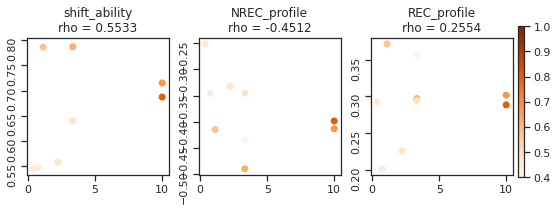

In [118]:
scatter_dose_dep(cell_line='A375',
                 compound='PF-03758309',
                 merged_rs_cp_table=merged_rs_cp_table,
                 tas=sig_info,
                 dose_dep_table=dose_dep)

<ipython-input-115-e8b61d064a0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_rs_cp['tas'] = tas['tas']


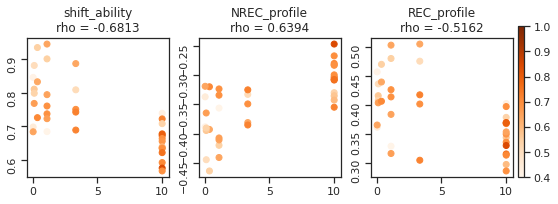

In [116]:
scatter_dose_dep(cell_line='A549',
                 compound='doxorubicin',
                 merged_rs_cp_table=merged_rs_cp_table,
                 tas=sig_info,
                 dose_dep_table=dose_dep)

<ipython-input-115-e8b61d064a0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_rs_cp['tas'] = tas['tas']


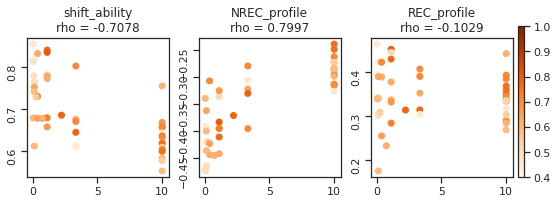

In [121]:
scatter_dose_dep(cell_line='MCF7',
                 compound='doxorubicin',
                 merged_rs_cp_table=merged_rs_cp_table,
                 tas=sig_info,
                 dose_dep_table=dose_dep)

<ipython-input-115-e8b61d064a0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_rs_cp['tas'] = tas['tas']


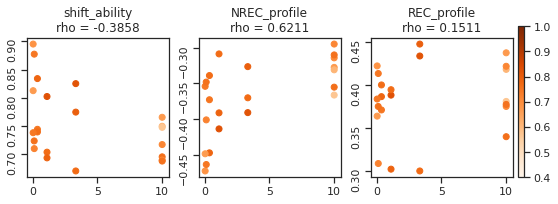

In [122]:
scatter_dose_dep(cell_line='A375',
                 compound='doxorubicin',
                 merged_rs_cp_table=merged_rs_cp_table,
                 tas=sig_info,
                 dose_dep_table=dose_dep)

<ipython-input-115-e8b61d064a0b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp_rs_cp['tas'] = tas['tas']


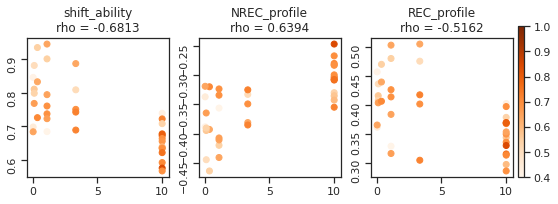

In [123]:
scatter_dose_dep(cell_line='A549',
                 compound='doxorubicin',
                 merged_rs_cp_table=merged_rs_cp_table,
                 tas=sig_info,
                 dose_dep_table=dose_dep)

### Association between tas-dosage dependence and shift-dosage dependence

<AxesSubplot:xlabel='tas_r', ylabel='shift_r'>

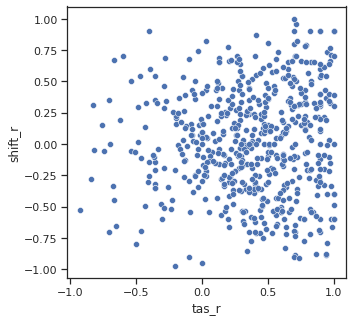

In [65]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='tas_r', y='shift_r', data=dose_dep) # did not observe significance

In [66]:
stats.spearmanr(dose_dep['tas_r'], dose_dep['shift_r'])

SpearmanrResult(correlation=0.05252545538851502, pvalue=0.2069381801011592)

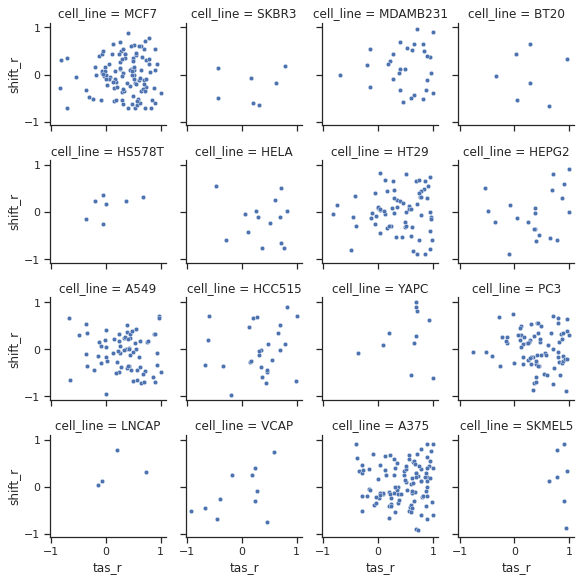

In [136]:
sns.relplot(x='tas_r', y='shift_r',
            col='cell_line', col_wrap=4,
            s=20, height=2, aspect=1,
            data=dose_dep)

<AxesSubplot:xlabel='tas_r', ylabel='NREC_r'>

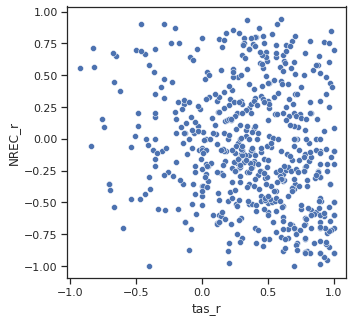

In [67]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='tas_r', y='NREC_r', data=dose_dep)

In [68]:
stats.spearmanr(dose_dep['tas_r'], dose_dep['NREC_r'])

SpearmanrResult(correlation=-0.2177486864864372, pvalue=1.2107569151501724e-07)

<AxesSubplot:xlabel='tas_r', ylabel='REC_r'>

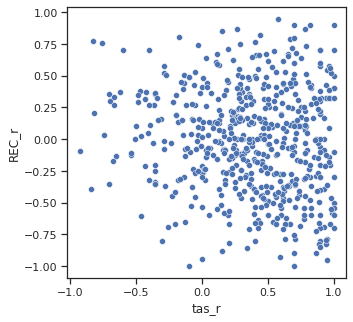

In [69]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='tas_r', y='REC_r', data=dose_dep)

In [70]:
stats.spearmanr(dose_dep['tas_r'], dose_dep['REC_r'])

SpearmanrResult(correlation=-0.1027485790858882, pvalue=0.013376454129647521)

## MOAs

In [46]:
cl_by_moa = df(index=drug_count['moa'].unique(), columns=top_R.columns)
for cl in top_R.columns:
    tmp_cl_R = df(top_R[cl])
    tmp_cl_R['moa'] = compound_info['moa']
    tmp_cl_R = tmp_cl_R[tmp_cl_R[cl] > 0].dropna(axis=0, how='any')
    cl_by_moa[cl] = tmp_cl_R['moa'].value_counts()
cl_by_moa = cl_by_moa.dropna(axis=0, how='all')
cl_by_moa = cl_by_moa.fillna(0)
cl_by_moa.to_csv(poseidon_home + 'results/compound_top_moa/top_Rshifting_moa_count.csv', sep=',')

In [47]:
moa_count = df(cl_by_moa.sum(axis=1))
moa_count = moa_count[moa_count[0] > 3].dropna(axis=0, how='any')
moa_count.shape

(50, 1)

In [48]:
top_cl_by_moa = cl_by_moa[cl_by_moa.index.isin(moa_count.index)]

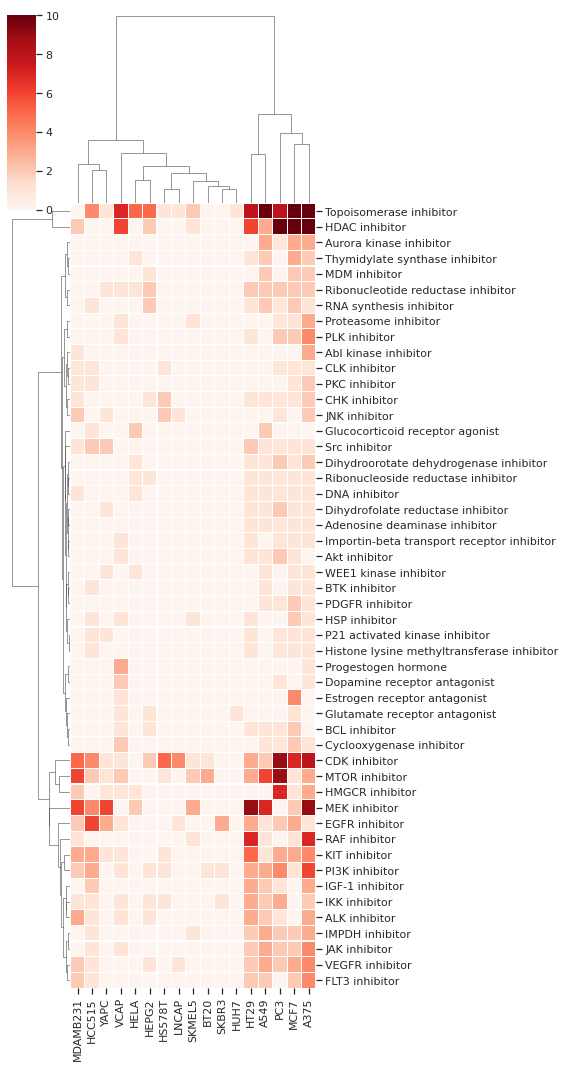

In [49]:
sns.clustermap(top_cl_by_moa,
               figsize=(8, 15),
               method='ward',
               cmap='Reds', vmin=0, vmax=10,
               linewidths=0.1)
fig = plt.gcf()
fig.savefig(panel_home + 'top_shift_cl_by_moa.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'top_shift_cl_by_moa.pdf', transparent=True)

# Immunogeneic cell death

In [138]:
enr_ifn_nes = []
enr_ifn_fdr = []

for ct in dose_dep['cancer_type'].unique():
    tmp_nes = pd.read_csv(gsea_home + ct + '/enr_result_trt_cp/nes_hallmark_IFN.csv',
                          index_col=0, header=0, sep=',')
    tmp_fdr = pd.read_csv(gsea_home + ct + '/enr_result_trt_cp/fdr_hallmark_IFN.csv',
                          index_col=0, header=0, sep=',')
    
    tmp_nes['cancer_type'] = ct
    tmp_fdr['cancer_type'] = ct
    
    enr_ifn_nes.append(tmp_nes)
    enr_ifn_fdr.append(tmp_fdr)

In [139]:
enr_ifn_nes_matrix = pd.concat(enr_ifn_nes, axis=0)
enr_ifn_nes_matrix

,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,cmap_name,nearest_dose,pert_idose,cancer_type
ABY001_SKBR3_XH:BRD-A61304759:0.625:24,-0.863017,-1.393600,-1.408472,tanespimycin,0.66,0.66 uM,BRCA
ABY001_SKBR3_XH:BRD-A61304759:10:24,-1.432136,-1.762094,-1.569211,tanespimycin,10.00,10 uM,BRCA
ABY001_SKBR3_XH:BRD-A61304759:2.5:24,-1.398923,-1.229592,-1.349167,tanespimycin,2.50,2.5 uM,BRCA
ABY001_SKBR3_XH:BRD-K19687926:0.625:24,0.754320,0.697921,0.786509,lapatinib,0.66,0.66 uM,BRCA
ABY001_SKBR3_XH:BRD-K19687926:10:24,0.632933,-0.821940,1.388737,lapatinib,10.00,10 uM,BRCA
...,...,...,...,...,...,...,...
REP.B028_A375_24H:K20,2.594172,2.315770,2.131658,brequinar,0.74,0.74 uM,SKCM
REP.B028_A375_24H:K21,2.380718,2.309238,1.805624,brequinar,0.25,0.25 uM,SKCM
REP.B028_A375_24H:L07,1.950852,2.343760,1.885631,BRD-K63750851,2.22,2.22 uM,SKCM
REP.B028_A375_24H:L08,1.642406,2.187147,2.295121,BRD-K63750851,0.74,0.74 uM,SKCM


In [140]:
enr_ifn_fdr_matrix = pd.concat(enr_ifn_fdr, axis=0)
enr_ifn_fdr_matrix

,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,cmap_name,nearest_dose,pert_idose,cancer_type
ABY001_SKBR3_XH:BRD-A61304759:0.625:24,0.796117,0.043689,0.029126,tanespimycin,0.66,0.66 uM,BRCA
ABY001_SKBR3_XH:BRD-A61304759:10:24,0.000000,0.000000,0.000000,tanespimycin,10.00,10 uM,BRCA
ABY001_SKBR3_XH:BRD-A61304759:2.5:24,0.045455,0.090909,0.045455,tanespimycin,2.50,2.5 uM,BRCA
ABY001_SKBR3_XH:BRD-K19687926:0.625:24,1.000000,0.952756,1.000000,lapatinib,0.66,0.66 uM,BRCA
ABY001_SKBR3_XH:BRD-K19687926:10:24,0.989051,0.884615,0.080292,lapatinib,10.00,10 uM,BRCA
...,...,...,...,...,...,...,...
REP.B028_A375_24H:K20,0.000000,0.000000,0.000000,brequinar,0.74,0.74 uM,SKCM
REP.B028_A375_24H:K21,0.000000,0.000000,0.000000,brequinar,0.25,0.25 uM,SKCM
REP.B028_A375_24H:L07,0.000000,0.000000,0.000000,BRD-K63750851,2.22,2.22 uM,SKCM
REP.B028_A375_24H:L08,0.000000,0.000000,0.000000,BRD-K63750851,0.74,0.74 uM,SKCM


In [141]:
enr_ifn_fdr_matrix['tas'] = sig_info['tas']
enr_ifn_nes_matrix['tas'] = sig_info['tas']

In [173]:
enr_ifn_fdr_matrix['cell_line'] = sig_info['cell_mfc_name']
enr_ifn_nes_matrix['cell_line'] = sig_info['cell_mfc_name']

In [174]:
enr_ifn_nes_matrix['dose_cat'] = merged_rs_cp_table['dosage']

In [221]:
enr_ifn_nes_matrix

,HALLMARK_INTERFERON_ALPHA_RESPONSE,HALLMARK_INTERFERON_GAMMA_RESPONSE,HALLMARK_INFLAMMATORY_RESPONSE,cmap_name,nearest_dose,pert_idose,cancer_type,tas,dose_cat,cell_line
ABY001_SKBR3_XH:BRD-A61304759:0.625:24,-0.863017,-1.393600,-1.408472,tanespimycin,0.66,0.66 uM,BRCA,0.467163,NaN,SKBR3
ABY001_SKBR3_XH:BRD-A61304759:10:24,-1.432136,-1.762094,-1.569211,tanespimycin,10.00,10 uM,BRCA,0.524551,NaN,SKBR3
ABY001_SKBR3_XH:BRD-A61304759:2.5:24,-1.398923,-1.229592,-1.349167,tanespimycin,2.50,2.5 uM,BRCA,0.499233,NaN,SKBR3
ABY001_SKBR3_XH:BRD-K19687926:0.625:24,0.754320,0.697921,0.786509,lapatinib,0.66,0.66 uM,BRCA,0.412509,low,SKBR3
ABY001_SKBR3_XH:BRD-K19687926:10:24,0.632933,-0.821940,1.388737,lapatinib,10.00,10 uM,BRCA,0.616939,medium,SKBR3
...,...,...,...,...,...,...,...,...,...,...
REP.B028_A375_24H:K20,2.594172,2.315770,2.131658,brequinar,0.74,0.74 uM,SKCM,0.695585,low,A375
REP.B028_A375_24H:K21,2.380718,2.309238,1.805624,brequinar,0.25,0.25 uM,SKCM,0.626767,low,A375
REP.B028_A375_24H:L07,1.950852,2.343760,1.885631,BRD-K63750851,2.22,2.22 uM,SKCM,0.696944,medium,A375
REP.B028_A375_24H:L08,1.642406,2.187147,2.295121,BRD-K63750851,0.74,0.74 uM,SKCM,0.648442,low,A375


In [175]:
enr_ifn_fdr_matrix.to_csv(poseidon_home + 'results/compound_top_moa/ifn_enr_fdr_dose_dep_subset.csv')
enr_ifn_nes_matrix.to_csv(poseidon_home + 'results/compound_top_moa/ifn_enr_nes_dose_dep_subset.csv')

In [222]:
# take only responder-shifting subset
enr_ifn_nes_rs = enr_ifn_nes_matrix.dropna(axis=0, how='any')
enr_ifn_fdr_rs = enr_ifn_fdr_matrix.dropna(axis=0, how='any')

## 0. Association between type I and type II

<AxesSubplot:xlabel='HALLMARK_INTERFERON_ALPHA_RESPONSE', ylabel='HALLMARK_INTERFERON_GAMMA_RESPONSE'>

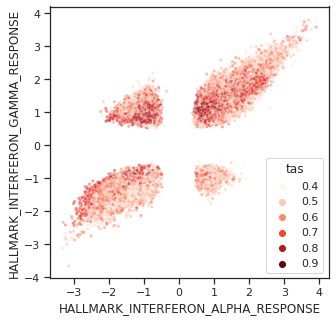

In [226]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='HALLMARK_INTERFERON_ALPHA_RESPONSE',
                y='HALLMARK_INTERFERON_GAMMA_RESPONSE',
                hue='tas',
                palette='Reds',
                s=10, alpha=0.5,
                data=enr_ifn_nes_matrix)

<AxesSubplot:xlabel='HALLMARK_INTERFERON_ALPHA_RESPONSE', ylabel='HALLMARK_INTERFERON_GAMMA_RESPONSE'>

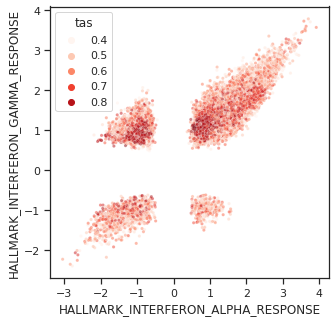

In [227]:
# show only R-shifting
plt.figure(figsize=(5, 5))
sns.scatterplot(x='HALLMARK_INTERFERON_ALPHA_RESPONSE',
                y='HALLMARK_INTERFERON_GAMMA_RESPONSE',
                hue='tas',
                palette='Reds',
                s=10, alpha=0.5,
                data=enr_ifn_nes_rs)

<AxesSubplot:xlabel='HALLMARK_INTERFERON_ALPHA_RESPONSE', ylabel='HALLMARK_INFLAMMATORY_RESPONSE'>

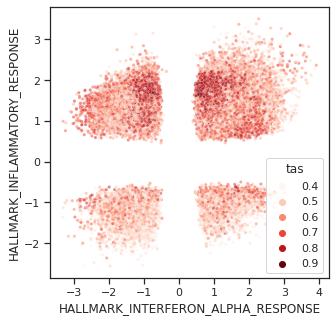

In [225]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='HALLMARK_INTERFERON_ALPHA_RESPONSE',
                y='HALLMARK_INFLAMMATORY_RESPONSE',
                hue='tas',
                palette='Reds',
                s=10, alpha=0.5,
                data=enr_ifn_nes_matrix)

<AxesSubplot:xlabel='HALLMARK_INTERFERON_GAMMA_RESPONSE', ylabel='HALLMARK_INFLAMMATORY_RESPONSE'>

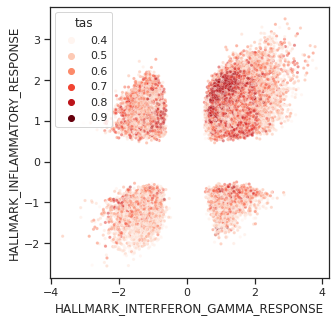

In [178]:
plt.figure(figsize=(5, 5))
sns.scatterplot(x='HALLMARK_INTERFERON_GAMMA_RESPONSE',
                y='HALLMARK_INFLAMMATORY_RESPONSE',
                hue='tas',
                palette='Reds',
                s=10, alpha=0.5,
                data=enr_ifn_nes_matrix)

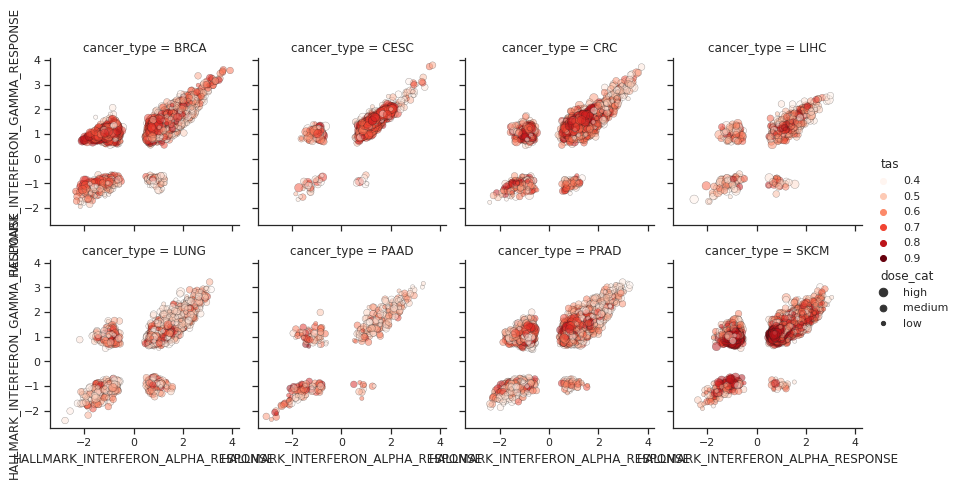

In [167]:
# alpha-gamma by cancer type
sns.relplot(x='HALLMARK_INTERFERON_ALPHA_RESPONSE',
            y='HALLMARK_INTERFERON_GAMMA_RESPONSE',
            col='cancer_type', col_wrap=4,
            size='dose_cat', size_order=['high', 'medium', 'low'],
            height=3, aspect=1,
            vmin=0.4, vmax=1,
            hue='tas', palette='Reds',
            alpha=0.5, edgecolor='k',
            data=enr_ifn_nes_matrix)
fig = plt.gcf()
fig.savefig(panel_home + 'IFN_response_by_cancer.png', dpi=300, transparent=True)
fig.savefig(panel_home + 'IFN_response_by_cancer.pdf', transparent=True)

## 1. Association between dosage and IFN response: all experiments

In [179]:
# dosage-dependence in each cell line
dose_dep_ifn = df(columns=['ifn_a_r', 'ifn_a_p', 'ifn_g_r', 'ifn_g_p',
                            'iflm_r', 'iflm_p', 'cell_line', 'cancer_type',
                           'cmap_name', '#experiments', 'moa', 'target'])
for ct in enr_ifn_nes_matrix['cancer_type'].unique():
    tmp_rs = enr_ifn_nes_matrix[enr_ifn_nes_matrix['cancer_type'] == ct]
    for cl in tmp_rs['cell_line'].unique():
        tmp_rs_cl = tmp_rs[tmp_rs['cell_line'] == cl]
        for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                tmp_a_r, tmp_a_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INTERFERON_ALPHA_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                tmp_g_r, tmp_g_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INTERFERON_GAMMA_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                tmp_m_r, tmp_m_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INFLAMMATORY_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                
                dose_dep_ifn.at[cl + '_' + d, 'ifn_a_r'] = tmp_a_r
                dose_dep_ifn.at[cl + '_' + d, 'ifn_a_p'] = tmp_a_p
                dose_dep_ifn.at[cl + '_' + d, 'ifn_g_r'] = tmp_g_r
                dose_dep_ifn.at[cl + '_' + d, 'ifn_g_p'] = tmp_g_p
                dose_dep_ifn.at[cl + '_' + d, 'iflm_r'] = tmp_m_r
                dose_dep_ifn.at[cl + '_' + d, 'iflm_p'] = tmp_m_p
                dose_dep_ifn.at[cl + '_' + d, 'cancer_type'] = ct
                dose_dep_ifn.at[cl + '_' + d, 'cell_line'] = cl
                dose_dep_ifn.at[cl + '_' + d, 'cmap_name'] = d
                dose_dep_ifn.at[cl + '_' + d, '#experiments'] = tmp_rs_cl_d.shape[0]
                dose_dep_ifn.at[cl + '_' + d, 'moa'] = compound_info.loc[d, 'moa']
                dose_dep_ifn.at[cl + '_' + d, 'target'] = compound_info.loc[d, 'target']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [199]:
dose_dep_ifn = dose_dep_ifn[dose_dep_ifn.index.isin(dose_dep.index)]

In [200]:
dose_dep_ifn.shape

(579, 12)

In [231]:
dose_dep_ifn.to_csv(poseidon_home + 'results/compound_top_moa/all_IFN_dose_dependence.csv', sep=',')

In [202]:
# dose-dep: IFNA vs.Shift
stats.spearmanr(dose_dep['shift_r'], dose_dep_ifn['ifn_a_r'])

SpearmanrResult(correlation=0.003358585955027597, pvalue=0.935727233843732)

In [203]:
# dose-dep: IFNG vs.Shift
stats.spearmanr(dose_dep['shift_r'], dose_dep_ifn['ifn_g_r'])

SpearmanrResult(correlation=0.025780969164612026, pvalue=0.5358407475079106)

In [204]:
# dose-dep: IFLM vs.Shift
stats.spearmanr(dose_dep['shift_r'], dose_dep_ifn['iflm_r'])

SpearmanrResult(correlation=0.05252991567645109, pvalue=0.2068995683911797)

<AxesSubplot:xlabel='shift_r', ylabel='ifn_a_r'>

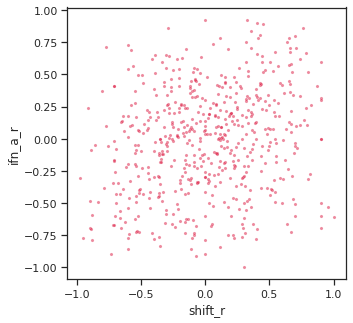

In [184]:
# dose-dep: IFNA vs.Shift
plt.figure(figsize=(5, 5))
sns.scatterplot(x=dose_dep['shift_r'],
                y=dose_dep_ifn['ifn_a_r'],
                color='crimson',
                s=10, alpha=0.5,)

<AxesSubplot:xlabel='shift_r', ylabel='ifn_g_r'>

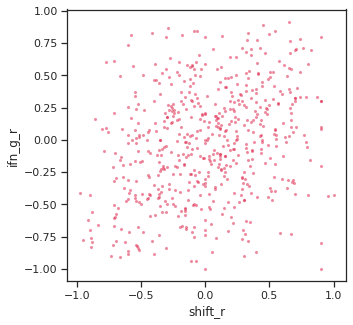

In [196]:
# dose-dep: IFNG vs.Shift
plt.figure(figsize=(5, 5))
sns.scatterplot(x=dose_dep['shift_r'],
                y=dose_dep_ifn['ifn_g_r'],
                color='crimson',
                s=10, alpha=0.5,)

<AxesSubplot:xlabel='shift_r', ylabel='iflm_r'>

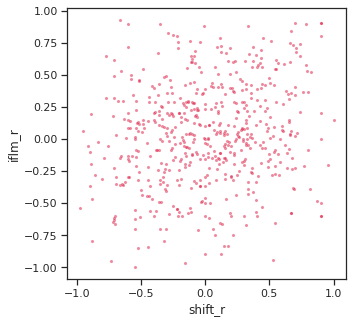

In [186]:
# dose-dep: IFLM vs.Shift
plt.figure(figsize=(5, 5))
sns.scatterplot(x=dose_dep['shift_r'],
                y=dose_dep_ifn['iflm_r'],
                color='crimson',
                s=10, alpha=0.5,)

In [209]:
# merge the dose dependence together into a matrix
dose_dep_merge = dose_dep_ifn[['ifn_a_r', 'ifn_g_r', 'iflm_r']]
dose_dep_merge['shift_r'] = dose_dep['shift_r']
dose_dep_merge['NREC_r'] = dose_dep['NREC_r']
dose_dep_merge['REC_r'] = dose_dep['REC_r']
dose_dep_merge = dose_dep_merge.fillna(0)

<ipython-input-209-3e61203dfa26>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_merge['shift_r'] = dose_dep['shift_r']
<ipython-input-209-3e61203dfa26>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_merge['NREC_r'] = dose_dep['NREC_r']
<ipython-input-209-3e61203dfa26>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

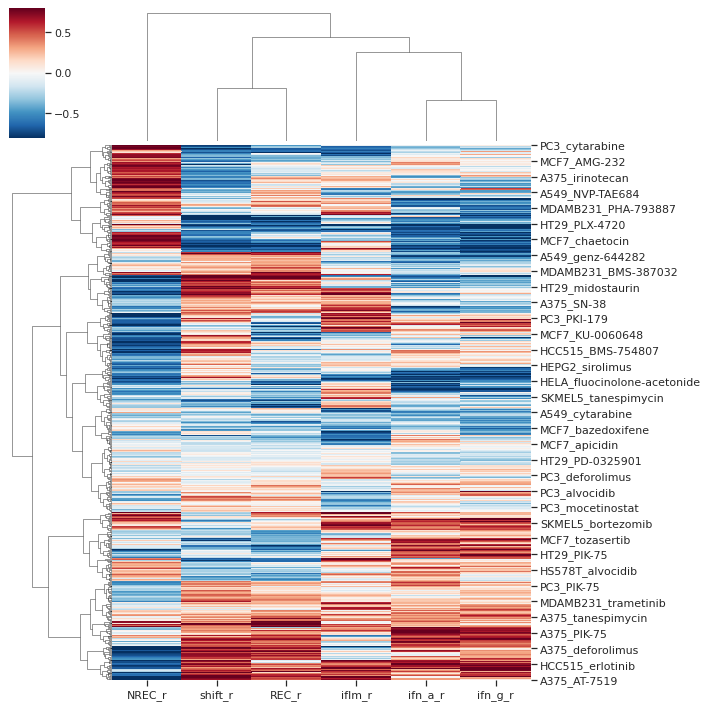

In [215]:
sns.clustermap(dose_dep_merge,
               vmin=-.8, vmax=.8,
               method='ward', cmap='RdBu_r')

In [218]:
dose_dep_ifn[dose_dep_ifn['moa'] == 'PARP inhibitor']

,ifn_a_r,ifn_a_p,ifn_g_r,ifn_g_p,iflm_r,iflm_p,cell_line,cancer_type,cmap_name,#experiments,moa,target
MCF7_AG-14361,0.414039,0.41443,0.20702,0.693907,-0.621059,0.188187,MCF7,BRCA,AG-14361,6,PARP inhibitor,PARP1


## 2. Association between dosage and IFN response: R-shifting experiments

In [228]:
# dosage-dependence in each cell line (R-shifting)
dose_dep_ifn_rs = df(columns=['ifn_a_r', 'ifn_a_p', 'ifn_g_r', 'ifn_g_p',
                            'iflm_r', 'iflm_p', 'cell_line', 'cancer_type',
                           'cmap_name', '#experiments', 'moa', 'target'])
for ct in enr_ifn_nes_rs['cancer_type'].unique():
    tmp_rs = enr_ifn_nes_rs[enr_ifn_nes_rs['cancer_type'] == ct]
    for cl in tmp_rs['cell_line'].unique():
        tmp_rs_cl = tmp_rs[tmp_rs['cell_line'] == cl]
        for d in tmp_rs_cl['cmap_name'].unique():
            tmp_rs_cl_d = tmp_rs_cl[tmp_rs_cl['cmap_name'] == d]
            if tmp_rs_cl_d.shape[0] >= 5:
                tmp_a_r, tmp_a_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INTERFERON_ALPHA_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                tmp_g_r, tmp_g_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INTERFERON_GAMMA_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                tmp_m_r, tmp_m_p = stats.spearmanr(tmp_rs_cl_d['HALLMARK_INFLAMMATORY_RESPONSE'], tmp_rs_cl_d['nearest_dose'])
                
                dose_dep_ifn_rs.at[cl + '_' + d, 'ifn_a_r'] = tmp_a_r
                dose_dep_ifn_rs.at[cl + '_' + d, 'ifn_a_p'] = tmp_a_p
                dose_dep_ifn_rs.at[cl + '_' + d, 'ifn_g_r'] = tmp_g_r
                dose_dep_ifn_rs.at[cl + '_' + d, 'ifn_g_p'] = tmp_g_p
                dose_dep_ifn_rs.at[cl + '_' + d, 'iflm_r'] = tmp_m_r
                dose_dep_ifn_rs.at[cl + '_' + d, 'iflm_p'] = tmp_m_p
                dose_dep_ifn_rs.at[cl + '_' + d, 'cancer_type'] = ct
                dose_dep_ifn_rs.at[cl + '_' + d, 'cell_line'] = cl
                dose_dep_ifn_rs.at[cl + '_' + d, 'cmap_name'] = d
                dose_dep_ifn_rs.at[cl + '_' + d, '#experiments'] = tmp_rs_cl_d.shape[0]
                dose_dep_ifn_rs.at[cl + '_' + d, 'moa'] = compound_info.loc[d, 'moa']
                dose_dep_ifn_rs.at[cl + '_' + d, 'target'] = compound_info.loc[d, 'target']

/home/dyang-server/anaconda3/lib/python3.8/site-packages/scipy/stats/stats.py:4196: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [229]:
dose_dep_ifn_rs = dose_dep_ifn_rs[dose_dep_ifn_rs.index.isin(dose_dep.index)]

In [240]:
dose_dep_ifn_rs

,ifn_a_r,ifn_a_p,ifn_g_r,ifn_g_p,iflm_r,iflm_p,cell_line,cancer_type,cmap_name,#experiments,moa,target
SKBR3_mitoxantrone,-0.882735,0.0198204,-0.882735,0.0198204,-0.971008,0.00124859,SKBR3,BRCA,mitoxantrone,6,Topoisomerase inhibitor,TOP2A
SKBR3_afatinib,0.343099,0.366029,-0.24268,0.529241,-0.426782,0.251957,SKBR3,BRCA,afatinib,9,EGFR inhibitor,EGFR
SKBR3_neratinib,0.24268,0.529241,0.610884,0.0805418,0.610884,0.0805418,SKBR3,BRCA,neratinib,9,EGFR inhibitor,EGFR
SKBR3_CGP-60474,0.250775,0.484646,-0.10398,0.774987,-0.373104,0.288275,SKBR3,BRCA,CGP-60474,10,CDK inhibitor,CDK1
SKBR3_alvocidib,0.257143,0.622787,0.142857,0.787172,-0.885714,0.0188455,SKBR3,BRCA,alvocidib,6,CDK inhibitor,CDK2
...,...,...,...,...,...,...,...,...,...,...,...,...
SKMEL5_mitoxantrone,-0.47265,0.0878737,-0.360648,0.205237,0.658574,0.0104345,SKMEL5,SKCM,mitoxantrone,14,Topoisomerase inhibitor,TOP2A
SKMEL5_selumetinib,-0.5,0.391002,-0.2,0.74706,0.9,0.0373861,SKMEL5,SKCM,selumetinib,5,MEK inhibitor,MAP2K1
SKMEL5_bortezomib,0.49793,0.172532,0.565446,0.11258,0.67516,0.0459878,SKMEL5,SKCM,bortezomib,9,Proteasome inhibitor,PSMB1
SKMEL5_dinaciclib,0.2,0.704,0.371429,0.468478,-0.6,0.208,SKMEL5,SKCM,dinaciclib,6,CDK inhibitor,CDK2


In [230]:
dose_dep_ifn_rs.to_csv(poseidon_home + 'results/compound_top_moa/all_Rshifting_IFN_dose_dependence.csv', sep=',')

In [237]:
# dose-dep: IFNA vs.Shift
stats.spearmanr(dose_dep['shift_r'], dose_dep_ifn_rs['ifn_g_r'])

SpearmanrResult(correlation=0.052891048129891954, pvalue=0.20379061038425755)

In [233]:
# merge the dose dependence together into a matrix
dose_dep_merge_rs = dose_dep_ifn_rs[['ifn_a_r', 'ifn_g_r', 'iflm_r']]
dose_dep_merge_rs['shift_r'] = dose_dep['shift_r']
dose_dep_merge_rs['NREC_r'] = dose_dep['NREC_r']
dose_dep_merge_rs['REC_r'] = dose_dep['REC_r']
dose_dep_merge_rs = dose_dep_merge_rs.fillna(0)

<ipython-input-233-746a792abce4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_merge_rs['shift_r'] = dose_dep['shift_r']
<ipython-input-233-746a792abce4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dose_dep_merge_rs['NREC_r'] = dose_dep['NREC_r']
<ipython-input-233-746a792abce4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

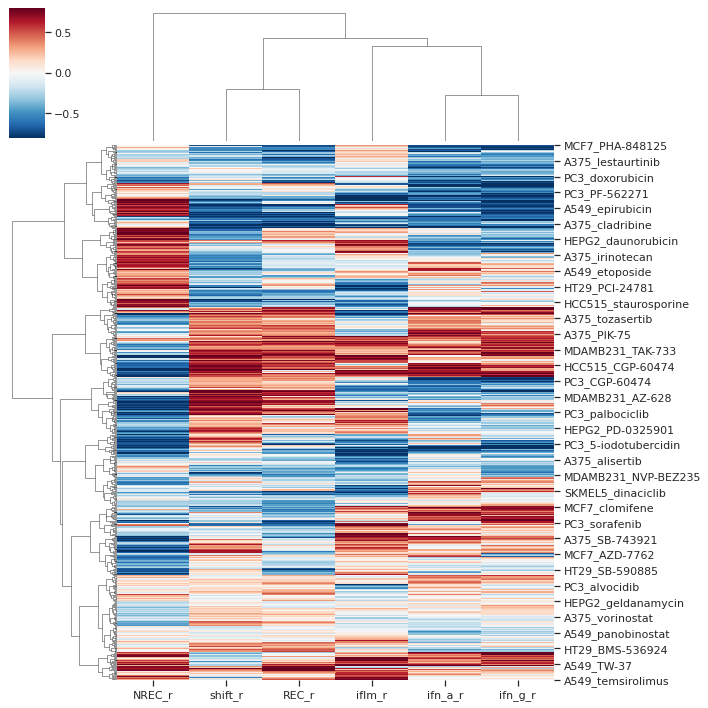

In [234]:
sns.clustermap(dose_dep_merge_rs,
               vmin=-.8, vmax=.8,
               method='ward', cmap='RdBu_r')

In [239]:
dose_dep_ifn_rs[dose_dep_ifn_rs['moa'] == 'PARP inhibitor']

,ifn_a_r,ifn_a_p,ifn_g_r,ifn_g_p,iflm_r,iflm_p,cell_line,cancer_type,cmap_name,#experiments,moa,target
MCF7_AG-14361,0,1,-0.353553,0.559404,-0.353553,0.559404,MCF7,BRCA,AG-14361,5,PARP inhibitor,PARP1
